In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
budg_fw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw

In [3]:
budg_fw = budg_fw.sel(time=slice('1993-01-01','2015-12-31'))

In [4]:
lfwc_spna = budg_fw.sel(region='spna',term='lfwc') - budg_fw.sel(region='spna',term='lfwc').mean('time')
lfwc_nsea = budg_fw.sel(region='nsea',term='lfwc') - budg_fw.sel(region='nsea',term='lfwc').mean('time')

In [5]:
ds = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [7]:
budg_fw_anom = budg_fw.groupby('time.month') - budg_fw.groupby('time.month').mean('time')

### Convert to dataframe

In [8]:
def convert_to_df(arr,region):
    
    # Load time series to dataframe
    df = arr.sel(region=region, term=['tendFw','forcFw','ConvFw','totalFw']).reset_coords(drop=True).to_dataframe()
    
    # Unstack
    df = df.unstack(level='term').reset_index()
    
    # Convert MultiIndex to Index
    df.columns = df.columns.map(''.join)
    
    # Set time as index
    df.set_index('time',inplace=True)
    
    # Rename columns
    df.rename(columns = lambda x : str(x)[7:],inplace=True)

    return df

In [9]:
df_spna = convert_to_df(budg_fw_anom,'spna')
df_nsea = convert_to_df(budg_fw_anom,'nsea')

`tendFw` = `forcFw` + `ConvFw` + `res`

In [10]:
df_spna['res'] = df_spna.tendFw - df_spna.totalFw
df_nsea['res'] = df_nsea.tendFw - df_nsea.totalFw

In [9]:
df_spna['dt'] = ds.reset_coords().dt.sel(time=slice('1993-01-01','2015-12-31')).to_dataframe().dt
df_nsea['dt'] = ds.reset_coords().dt.sel(time=slice('1993-01-01','2015-12-31')).to_dataframe().dt

In [10]:
# Replace nans with number of seconds for Dec 2015
df_spna = df_spna.fillna(31*24*60*60)
df_nsea = df_nsea.fillna(31*24*60*60)

### Annual (1-year average)
1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014

In [11]:
#df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_spna_sub = df_spna.loc[(df_spna.index > '1992-12-31')&(df_spna.index < '2016-01-01')]

df_spna_1yr = df_spna_sub.multiply(df_spna_sub["dt"], axis="index").resample('1A',kind='period').sum()

In [12]:
# Replace last row with previous row
df_spna_1yr.iloc[-1] = df_spna_1yr.iloc[-2]

# Convert index to timestamp
df_spna_1yr.index = df_spna_1yr.index.to_timestamp() + pd.Timedelta(days=-365)

### Remove `dt`

In [13]:
df_spna_1yr = df_spna_1yr.drop(columns=['dt'])

In [14]:
df_spna_1yr.head()

,ConvFw,forcFw,tendFw,totalFw,res
time,,,,,
1992-01-02,-8.239998e+05,4.772883e+06,1.970554e+06,3.948883e+06,-1.978330e+06
1993-01-01,-1.576716e+06,4.856989e+06,1.675409e+06,3.280273e+06,-1.604864e+06
1994-01-01,-2.699018e+06,4.979523e+06,5.875370e+05,2.280505e+06,-1.692968e+06
1995-01-01,-5.402637e+06,3.589266e+06,-3.094598e+06,-1.813370e+06,-1.281228e+06
1996-01-02,-4.441111e+06,3.658273e+06,-2.020335e+06,-7.828383e+05,-1.237497e+06


In [18]:
lfwc_spna_annual = lfwc_spna.groupby('time.year').mean('time')

In [21]:
lfwc_spna.time.min()

<xarray.DataArray 'time' ()>
array('1993-01-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    term     <U4 'lfwc'
    region   <U4 'spna'

### Plot

NameError: name 'df_spna_1yr' is not defined

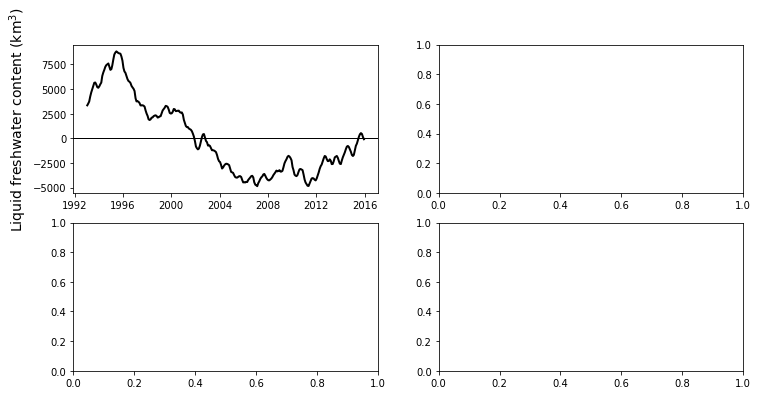

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(lfwc_spna.time, lfwc_spna*1e-3, lw=2, color='black', label='monthly')
#axs[0,0].plot(lfwc_spna_annual.year, lfwc_spna_annual, lw=3, marker='o',ms=12,color='k',label='annual')
#axs[0,0].set_xlim([df_spna_1yr.index.min()+timedelta(days=-359),df_spna_1yr.index.max()+timedelta(days=365)])
#axs[0,0].set_ylim([-0.12, 0.09])
axs[0,0].set_ylabel(r'Liquid freshwater content (km$^3$)',fontsize=14)


axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
bar_width = 345
for term in [df_spna_1yr[df_spna_1yr>0].fillna(0)[:-1],df_spna_1yr[df_spna_1yr<0].fillna(0)[:-1]]:
    p1 = axs[1,0].bar(term.index+timedelta(days=10), term.forcFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='blue',   bottom=0)
    p2 = axs[1,0].bar(term.index+timedelta(days=10), term.ConvFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='red',    bottom=term.forcFw)
    p3 = axs[1,0].bar(term.index+timedelta(days=10), term.res*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='orange', bottom=term.forcFw+term.ConvFw)
p1.set_label('Forcing')
p2.set_label('Advection')
p3.set_label('Residual')

p0 = axs[1,0].step(df_spna_1yr.index,df_spna_1yr.tendFw*1e-3,where='post',c='k',lw=2,linestyle='-',label='Total tendency')
#axs[1,0].set_xlim([df_spna_1yr.index.min()+timedelta(days=-359),df_spna_1yr.index.max()+timedelta(days=365)])
#axs[1,0].set_ylim([-0.25,0.343])

axs[1,0].set_ylabel(r'Freshwater flux (km$^3$ yr$^{-1}$)',fontsize=14)


#axs[0,0].figure.autofmt_xdate()
#axs[0,0].xaxis.set_major_locator(dates.YearLocator())
#axs[0,0].xaxis.set_minor_locator(dates.YearLocator(month=7))
#axs[0,0].yaxis.set_tick_params(labelsize=12)

#axs[1,0].figure.autofmt_xdate()
#axs[1,0].xaxis.set_major_locator(dates.YearLocator())
#axs[1,0].xaxis.set_minor_locator(dates.YearLocator(month=7))
#axs[1,0].yaxis.set_tick_params(labelsize=12)

#axs[0,0].text(0.01,0.90, 'a', transform=axs[0,0].transAxes, fontsize=14, fontweight='bold')
#axs[1,0].text(0.01,0.90, 'b', transform=axs[1,0].transAxes, fontsize=14, fontweight='bold')
#axs[0,1].text(0.01,0.90, 'c', transform=axs[2,0].transAxes, fontsize=14, fontweight='bold')
#axs[1,1].text(0.01,0.90, 'd', transform=axs[3,0].transAxes, fontsize=14, fontweight='bold')


fig.subplots_adjust(left=0.1, right=0.87, bottom=0.1, top=0.9, hspace=0.05, wspace=0.05)

#plt.savefig('/tmp/figure.png')
#plt.savefig('/tmp/figure.eps')

plt.show()

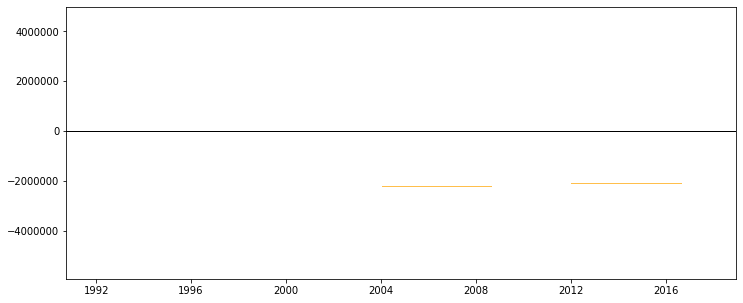

In [30]:
fig = plt.figure(figsize=(12, 5))
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

bar_width = 1700

for term in [df_spna_1yr[df_spna_1yr>0].fillna(0)[:-1],df_spna_1yr[df_spna_1yr<0].fillna(0)[:-1]]:
    p1 = plt.bar(term.index+timedelta(days=10), term.forcFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='blue',   bottom=0)
    p2 = plt.bar(term.index+timedelta(days=10), term.ConvFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='red',    bottom=term.forcFw)
    p3 = plt.bar(term.index+timedelta(days=10), term.res*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='orange', bottom=term.forcFw+term.ConvFw)
    
p1.set_label('Forcing')
p2.set_label('Advection')
p3.set_label('Residual')

<BarContainer object of 23 artists>

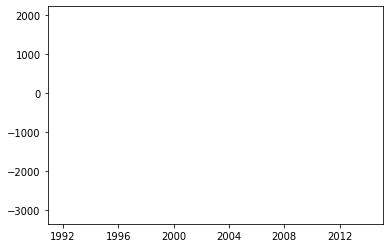

In [35]:
plt.bar(df_spna_1yr.index, df_spna_1yr.tendFw*1e-3)

In [ ]:
lfwc_spna 

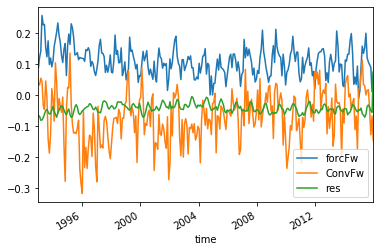

In [49]:
df_spna[['forcFw','ConvFw','res']].plot()

time
1993-01-15 00:00:00    0.059207
1993-02-12 00:00:00    0.084461
1993-03-15 00:00:00    0.113810
1993-04-14 00:00:00    0.219190
1993-05-15 00:00:00    0.118338
                         ...   
2015-08-15 00:00:00    0.091425
2015-09-14 00:00:00    0.013434
2015-10-15 00:00:00   -0.089728
2015-11-14 00:00:00   -0.112782
2015-12-14 12:00:00    0.000000
Name: tendFw, Length: 276, dtype: float64

In [68]:
df.head()

,forcFw,ConvFw,res
time,,,
1993-01-15,0.000088,0.000037,-0.000066
1993-02-12,0.000121,0.000032,-0.000069
1993-03-15,0.000141,0.000054,-0.000082
1993-04-14,0.000256,0.000043,-0.000081
1993-05-15,0.000226,-0.000034,-0.000073


In [ ]:
,df_spna_1yr[df_spna_1yr<0].fillna(0)[:-1]]

In [11]:
df = df_spna[['forcFw','ConvFw','res']]*1e3
sum_all_pos = df[df>0].fillna(0)[:-1].sum(axis=1)
sum_all_neg = df[df<0].fillna(0)[:-1].sum(axis=1)

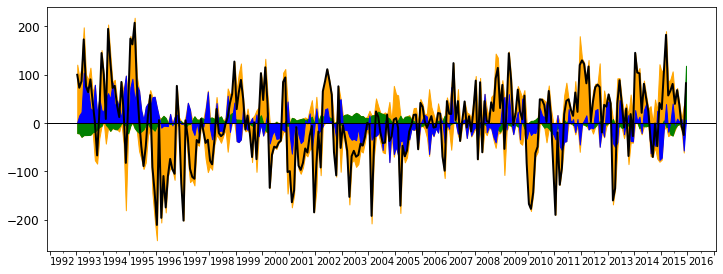

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(df_spna.index, df_spna.tendFw*1e3, lw=2, color='black')

ax.fill_between(sum_all_pos.index, 0, sum_all_pos,color='orange')
ax.fill_between(sum_all_neg.index, 0, sum_all_neg,color='orange')
ax.fill_between(df.index, 0, df.res, color='green')
ax.fill_between(df.index, 0, df.forcFw, color='blue')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
ax.figure.autofmt_xdate()


ax.yaxis.set_tick_params(labelsize=12)
plt.show()

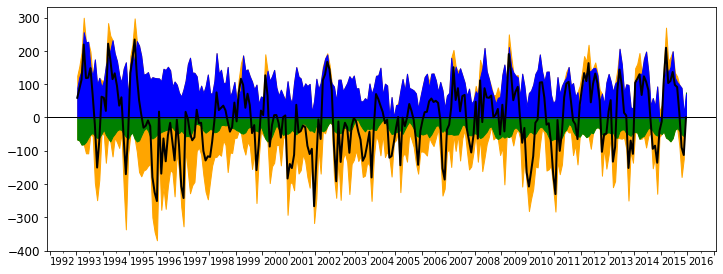

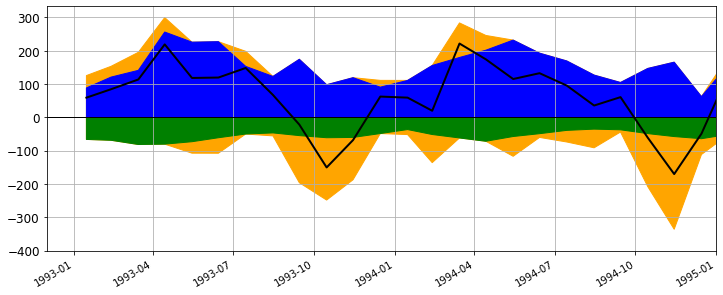

In [119]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(df_spna.index, df_spna.tendFw*1e3, lw=2, color='black')

ax.fill_between(sum_pos.index, 0, sum_all_pos,color='orange')
ax.fill_between(sum_neg.index, 0, sum_all_neg,color='orange')
ax.fill_between(df.index, 0, df.res, color='green')
ax.fill_between(df.index, 0, df.forcFw, color='blue')

#ax.xaxis.set_major_locator(dates.YearLocator())
#ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
#ax.xaxis.set_major_formatter(ticker.NullFormatter())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
ax.figure.autofmt_xdate()
ax.grid(True)
ax.set_xlim(['1992-12-01','1995-01-01'])
ax.yaxis.set_tick_params(labelsize=12)
plt.show()

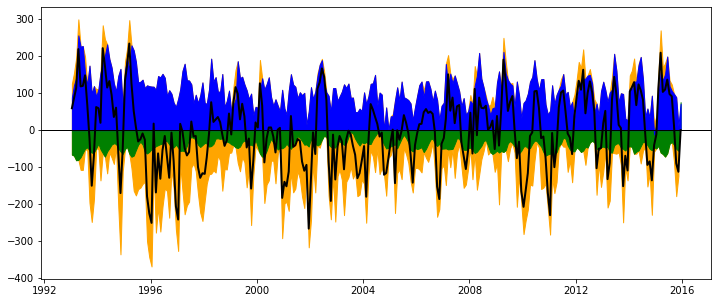

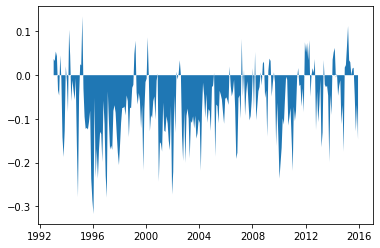

In [66]:
p1 = plt.stackplot(df_spna.index, df_spna.ConvFw)

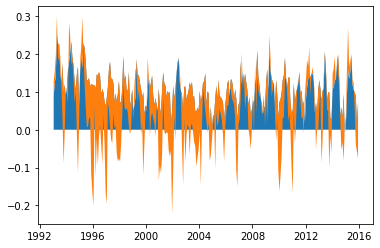

In [64]:
p1 = plt.stackplot(df_spna.index, df_spna.forcFw,df_spna.ConvFw)

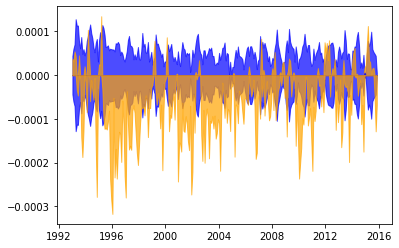

In [60]:
for term in [df[df>0].fillna(0)[:-1],df[df<0].fillna(0)[:-1]]:
    p1 = plt.stackplot(term.index, term.forcFw*1e-3, alpha=0.7, color='blue', baseline='wiggle')
    p2 = plt.stackplot(term.index, term.ConvFw*1e-3, alpha=0.7, color='orange')

In [ ]:
for term in [df[df>0].fillna(0)[:-1],df[df<0].fillna(0)[:-1]]:
    p1 = plt.bar(term.index+timedelta(days=10), term.forcFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='blue',   bottom=0)
    p2 = plt.bar(term.index+timedelta(days=10), term.ConvFw*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='red',    bottom=term.forcFw)
    p3 = plt.bar(term.index+timedelta(days=10), term.res*1e-3, bar_width, 
                 align='edge', alpha=0.7, color='orange', bottom=term.forcFw+term.ConvFw)

ValueError: When stacked is True, each column must be either all positive or negative.forcFw contains both positive and negative values

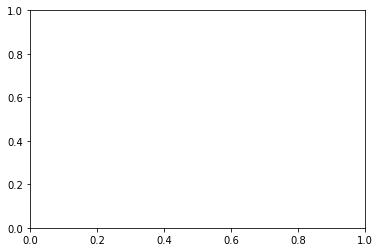

In [51]:
df_spna[['forcFw','ConvFw','res']].plot.area()

In [ ]:
df_spna_1yr = df_spna_1yr

ValueError: Could not convert object to NumPy datetime

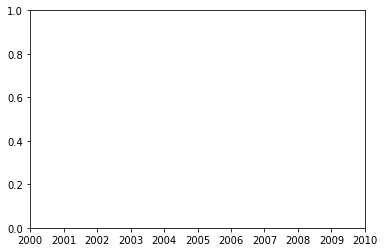

In [46]:
plt.stackplot(budg_fw.time,budg_fw.sel(region='spna',term='forcFw'))

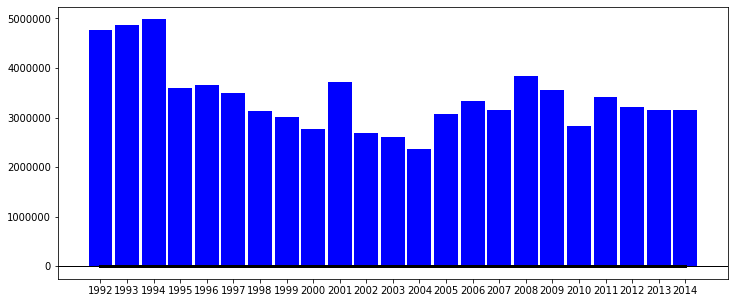

In [39]:
fig = plt.figure(figsize=(12, 5))
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

p1 = plt.bar(df_spna_1yr.index.strftime('%Y'), df_spna_1yr.forcFw, 0.9, color='blue')
plt.step(df_spna_1yr.index.strftime('%Y'), df_spna_1yr.tendFw*1e-3, where='mid', c='k', lw=3, linestyle='-')


#plt.ylim([-4000,4000])

plt.show()

In [ ]:
for term in [df_1yr[df_1yr>0].fillna(0),df_1yr[df_1yr<0].fillna(0)]:
    p1 = plt.bar(term.index.strftime('%Y'), term.frc, 0.9, color='blue', bottom=0)
    p2 = plt.bar(term.index.strftime('%Y'), term.adv, 0.9, color='red', bottom=term.frc)
    p3 = plt.bar(term.index.strftime('%Y'), term.dif, 0.9, color='orange', bottom=term.frc+term.adv)
    p4 = plt.bar(term.index.strftime('%Y'), term.res, 0.9, color='green', bottom=term.frc+term.adv+term.dif)

plt.step(df_1yr.index.strftime('%Y'), df_1yr.tnd, where='mid', c='k', lw=3, linestyle='-')
#plt.title('Atlantic basin',fontsize=16)

#plt.xlim(['1992-11-15','2015-02-15'])

In [ ]:
import numpy as NP
from matplotlib import pyplot as PLT

# just create some random data
fnx = lambda : NP.random.randint(3, 10, 10)
y = NP.row_stack((fnx(), fnx(), fnx()))   
# this call to 'cumsum' (cumulative sum), passing in your y data, 
# is necessary to avoid having to manually order the datasets
x = NP.arange(10) 
y_stack = NP.cumsum(y, axis=0)   # a 3x10 array

fig = PLT.figure()
ax1 = fig.add_subplot(111)

ax1.fill_between(x, 0, y_stack[0,:], facecolor="#CC6666", alpha=.7)
ax1.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor="#1DACD6", alpha=.7)
ax1.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor="#6E5160")

PLT.show()

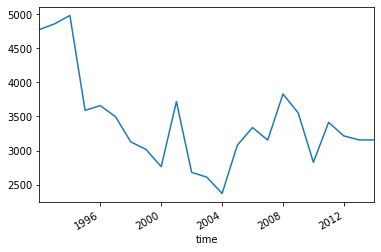

In [33]:
(df_spna_1yr.forcFw*1e-3).plot()